In [1]:
from __future__ import annotations

from typing import Tuple, Dict, Optional

In [52]:
import torch
from torch import nn

In [3]:
class RepVGGTrainBlock(nn.Module):
    
    def __init__(self, channels: int):
        super().__init__()
        self.conv_3x3 = nn.Conv2d(
            in_channels=channels, 
            out_channels=channels,
            kernel_size=3,
            padding=1,
            bias=False,
        )
        self.conv_3x3_bn = nn.BatchNorm2d(
            num_features=channels,
        )
        self.conv_1x1 = nn.Conv2d(
            in_channels=channels, 
            out_channels=channels,
            kernel_size=1,
            padding=0,
            bias=False,
        )
        self.conv_1x1_bn = nn.BatchNorm2d(
            num_features=channels,
        )
        self.identity_bn = nn.BatchNorm2d(
            num_features=channels,
        )
        
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        conv_3x3_out = self.conv_3x3(x)
        conv_1x1_out = self.conv_1x1(x)
        return self.conv_3x3_bn(conv_3x3_out) \
            + self.conv_1x1_bn(conv_1x1_out) \
            + self.identity_bn(x)
    
    
class RepVGGInferenceBlock(nn.Module):
    
    @classmethod
    def from_training_block(cls, block: RepVGGTrainBlock) -> RepVGGInferenceBlock:
        conv_3x3_params = extract_conv2d_parameters(conv_2d=block.conv_3x3)
        conv_3x3_bn_params = extract_batch_norm_parameters(batch_norm=block.conv_3x3_bn)
        conv_1x1_params = extract_conv2d_parameters(conv_2d=block.conv_1x1)
        conv_1x1_bn_params = extract_batch_norm_parameters(batch_norm=block.conv_1x1_bn)
        identity_bn_params = extract_batch_norm_parameters(batch_norm=block.identity_bn)
        conv_3x3_kernel_reparametrised, conv_3x3_bias_reparametrised = reparametrise_conv(
            kernel=conv_3x3_params[0],
            bn_parameters=conv_3x3_bn_params,
        )
        conv_1x1_kernel_reparametrised, conv_1x1_bias_reparametrised = reparametrise_conv(
            kernel=conv_1x1_params[0],
            bn_parameters=conv_1x1_bn_params,
        )
        conv_1x1_kernel_reparametrised_upsampled = conv1x1_to_conv3x3(
            kernel=conv_1x1_kernel_reparametrised,
        )
        identity_kernel = construct_conv3x3_identity_kernel(
            identity_kernel=conv_1x1_kernel_reparametrised,
        )
        identyity_kernel_reparametrised, identity_bias_reparametrised = reparametrise_conv(
            kernel=identity_kernel,
            bn_parameters=identity_bn_params,
        )
        new_kernel = \
            conv_3x3_kernel_reparametrised + conv_1x1_kernel_reparametrised_upsampled \
            + identyity_kernel_reparametrised
        new_bias = conv_3x3_bias_reparametrised + conv_1x1_bias_reparametrised + identity_bias_reparametrised
        out_channels, in_channels = new_kernel.shape[:2]
        target_convolution = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size=3,
            padding=1,
        )
        target_convolution.weight = nn.Parameter(new_kernel)
        target_convolution.bias = nn.Parameter(new_bias)
        return cls(convolution=target_convolution)
        
    def __init__(self, convolution: nn.Conv2d):
        super().__init__()
        self.convolution = convolution
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.convolution(x)
        
        
    
def extract_batch_norm_parameters(
    batch_norm: nn.BatchNorm2d
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    parameters = collect_parameters(module=batch_norm)
    running_std = (batch_norm.running_var + batch_norm.eps).sqrt()
    return batch_norm.running_mean, running_std, parameters["weight"], parameters["bias"]


def extract_conv2d_parameters(conv_2d: nn.Conv2d) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
    parameters = collect_parameters(module=conv_2d)
    return parameters["weight"], parameters.get("bias")


def collect_parameters(module: nn.Module) -> Dict[str, torch.Tensor]:
    return {
        p[0].split(".")[-1]: p[1].data
        for p in module.named_parameters()
    }


def reparametrise_conv(
    kernel: torch.Tensor,
    bn_parameters: Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]
) -> Tuple[torch.Tensor, torch.Tensor]:
    result_kernel = kernel.clone()
    kernel_multiplier = bn_parameters[2] / bn_parameters[1]
    for i in range(kernel.shape[0]):
        result_kernel[i] *= kernel_multiplier[i]
    bias_reparametrised = -(bn_parameters[2] * bn_parameters[0]) / bn_parameters[1] + bn_parameters[3]
    return result_kernel, bias_reparametrised


def conv1x1_to_conv3x3(kernel: torch.Tensor) -> torch.Tensor:
    out_channels, in_channels = kernel.shape[:2]
    new_kernel = torch.zeros((out_channels, in_channels, 3, 3), dtype=kernel.dtype)
    for out_ch in range(out_channels):
        for in_ch in range(in_channels):
            new_kernel[out_ch, in_ch, 1, 1] = kernel[out_ch, in_ch, 0, 0]
    return new_kernel


def construct_conv3x3_identity_kernel(
    identity_kernel: torch.Tensor,
) -> torch.Tensor:
    out_channels, in_channels = identity_kernel.shape[:2]
    identity_kernel = torch.zeros((out_channels, in_channels, 3, 3), dtype=identity_kernel.dtype)
    if in_channels != out_channels:
        raise RuntimeError(
            "While construction of identity 1x1 conv kernel found different input and output "
            f"channels number: {in_channels} and {out_channels} respectively."
        )
    for i in range(out_channels):
        identity_kernel[i][i][1][1] = 1.0
    return identity_kernel

In [5]:
def prepare_tensor(
    batch_size: int,
    channels: int,
    height: int,
    width: int,
) -> torch.Tensor:
    return torch.rand((batch_size, channels, height, width))

In [6]:
import time
import statistics
from tqdm import tqdm

def execute_test(
    batch_size: int,
    channels: int,
    height: int,
    width: int,
) -> tuple:
    with torch.no_grad():
        source_module = RepVGGTrainBlock(channels).to(torch.device("cuda:0"))
        
        print("Warmpup")
        for _ in tqdm(range(20)):
            x = prepare_tensor(
                batch_size=batch_size,
                channels=channels,
                height=height,
                width=width,
            ).to(torch.device("cuda:0"))
            _ = source_module(x)
        source_module.eval()
        x = prepare_tensor(
            batch_size=batch_size,
            channels=channels,
            height=height,
            width=32,
        ).to(torch.device("cuda:0"))
        reference_result = source_module(x)
        optimised_module = RepVGGInferenceBlock.from_training_block(
            source_module.to(torch.device("cpu"))
        ).to(torch.device("cuda:0"))
        result = optimised_module(x)
        assert (result - reference_result < 1e-3).all()
        
        print("test")
        source_module.to(torch.device("cuda:0"))
        times_not_optimised = []
        for _ in tqdm(range(100)):
            x = prepare_tensor(
                batch_size=batch_size,
                channels=channels,
                height=height,
                width=width,
            ).to(torch.device("cuda:0"))
            start = time.time()
            _ = source_module(x)
            duration = time.time() - start
            times_not_optimised.append(duration)
        
        
        times_optimised = []
        for _ in tqdm(range(100)):
            x = prepare_tensor(
                batch_size=batch_size,
                channels=channels,
                height=height,
                width=width,
            ).to(torch.device("cuda:0"))
            start = time.time()
            _ = optimised_module(x)
            duration = time.time() - start
            times_optimised.append(duration)
        
        del source_module
        del optimised_module
        torch.cuda.empty_cache()
        return times_not_optimised, times_optimised

In [7]:
BATCH_SIZES = [1, 2, 4, 8, 16, 32, 64]
CHANNELS = [3, 8, 16, 32, 64, 128, 256]
SIZES = [128, 64, 32, 16, 8]

In [8]:
results = {}

for batch_size in BATCH_SIZES:
    for channels in CHANNELS:
        for image_size in SIZES:
            print(f"Executing test for bs={batch_size}, c={channels}, img_size={image_size}")
            times_not_optimised, times_optimised = execute_test(
                batch_size=batch_size,
                channels=channels,
                height=image_size,
                width=image_size,
            )
            results[(batch_size, channels, image_size)] = {
                "not_optimised": times_not_optimised,
                "optimised": times_optimised
            }

Executing test for bs=1, c=3, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 12.93it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 3396.12it/s]


Executing test for bs=1, c=3, img_size=64
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2149.05it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 6598.97it/s]


Executing test for bs=1, c=3, img_size=32
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2726.23it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7693.01it/s]


Executing test for bs=1, c=3, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2355.82it/s]


test


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 10299.59it/s]


Executing test for bs=1, c=3, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2561.17it/s]


test


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 10581.26it/s]


Executing test for bs=1, c=8, img_size=128
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 956.81it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1432.49it/s]


Executing test for bs=1, c=8, img_size=64
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1538.46it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 3695.81it/s]


Executing test for bs=1, c=8, img_size=32
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2383.67it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7286.08it/s]


Executing test for bs=1, c=8, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2793.32it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7525.17it/s]

Executing test for bs=1, c=8, img_size=8


Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2441.03it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 8061.63it/s]


Executing test for bs=1, c=16, img_size=128
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 668.61it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 797.34it/s]


Executing test for bs=1, c=16, img_size=64
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1423.22it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2490.27it/s]


Executing test for bs=1, c=16, img_size=32
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2259.74it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 5152.14it/s]


Executing test for bs=1, c=16, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2684.35it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7636.70it/s]


Executing test for bs=1, c=16, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2709.76it/s]


test


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 10129.70it/s]


Executing test for bs=1, c=32, img_size=128
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 380.55it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 412.63it/s]


Executing test for bs=1, c=32, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 898.55it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1438.92it/s]


Executing test for bs=1, c=32, img_size=32
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1858.60it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 4073.92it/s]


Executing test for bs=1, c=32, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2568.31it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7354.56it/s]


Executing test for bs=1, c=32, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2872.81it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 9215.62it/s]


Executing test for bs=1, c=64, img_size=128
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 202.29it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 213.12it/s]


Executing test for bs=1, c=64, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 654.49it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 791.05it/s]


Executing test for bs=1, c=64, img_size=32
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1572.23it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2561.31it/s]


Executing test for bs=1, c=64, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2309.19it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 5992.72it/s]


Executing test for bs=1, c=64, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1838.08it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 8848.00it/s]


Executing test for bs=1, c=128, img_size=128
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 102.04it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 107.08it/s]


Executing test for bs=1, c=128, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 377.50it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 414.32it/s]


Executing test for bs=1, c=128, img_size=32
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1093.85it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1465.38it/s]


Executing test for bs=1, c=128, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1837.35it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 3987.17it/s]


Executing test for bs=1, c=128, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2223.21it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 6634.14it/s]


Executing test for bs=1, c=256, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 51.16it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 52.90it/s]


Executing test for bs=1, c=256, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 190.61it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 215.74it/s]


Executing test for bs=1, c=256, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 658.37it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 788.47it/s]


Executing test for bs=1, c=256, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1634.79it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2576.34it/s]


Executing test for bs=1, c=256, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2557.89it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 4159.32it/s]


Executing test for bs=2, c=3, img_size=128
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1138.66it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1869.28it/s]


Executing test for bs=2, c=3, img_size=64
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2137.39it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 4332.02it/s]


Executing test for bs=2, c=3, img_size=32
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2536.62it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 8250.33it/s]


Executing test for bs=2, c=3, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2498.99it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 9904.37it/s]


Executing test for bs=2, c=3, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 3210.34it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 8377.05it/s]


Executing test for bs=2, c=8, img_size=128
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 635.95it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 823.90it/s]


Executing test for bs=2, c=8, img_size=64
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1734.65it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2446.93it/s]


Executing test for bs=2, c=8, img_size=32
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2198.16it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 5271.74it/s]


Executing test for bs=2, c=8, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2970.15it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 8652.69it/s]


Executing test for bs=2, c=8, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2655.46it/s]


test


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 10181.59it/s]


Executing test for bs=2, c=16, img_size=128
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 362.71it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 424.40it/s]


Executing test for bs=2, c=16, img_size=64
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1007.46it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1450.21it/s]


Executing test for bs=2, c=16, img_size=32
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1857.61it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 4047.58it/s]


Executing test for bs=2, c=16, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2325.52it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 6881.44it/s]


Executing test for bs=2, c=16, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 3131.48it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7933.09it/s]


Executing test for bs=2, c=32, img_size=128
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 200.69it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 214.51it/s]


Executing test for bs=2, c=32, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 659.66it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 809.14it/s]


Executing test for bs=2, c=32, img_size=32
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1686.53it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2504.17it/s]


Executing test for bs=2, c=32, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2740.57it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 5498.27it/s]


Executing test for bs=2, c=32, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2491.94it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7168.40it/s]


Executing test for bs=2, c=64, img_size=128
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 102.65it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 107.36it/s]


Executing test for bs=2, c=64, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 383.18it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 422.96it/s]


Executing test for bs=2, c=64, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 977.52it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1507.42it/s]


Executing test for bs=2, c=64, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1843.77it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 4127.16it/s]


Executing test for bs=2, c=64, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2457.77it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7572.45it/s]


Executing test for bs=2, c=128, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 53.40it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 54.16it/s]


Executing test for bs=2, c=128, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 202.66it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 218.10it/s]


Executing test for bs=2, c=128, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 621.37it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 776.86it/s]


Executing test for bs=2, c=128, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1360.00it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2459.96it/s]


Executing test for bs=2, c=128, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2594.60it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 6052.91it/s]


Executing test for bs=2, c=256, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 27.50it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 22.61it/s]


Executing test for bs=2, c=256, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 104.21it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 107.18it/s]


Executing test for bs=2, c=256, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 385.53it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 418.26it/s]


Executing test for bs=2, c=256, img_size=16
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 939.53it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1457.88it/s]


Executing test for bs=2, c=256, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2177.22it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 3818.52it/s]


Executing test for bs=4, c=3, img_size=128
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 796.24it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1064.08it/s]


Executing test for bs=4, c=3, img_size=64
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1625.42it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 3162.60it/s]


Executing test for bs=4, c=3, img_size=32
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2606.13it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 6744.56it/s]


Executing test for bs=4, c=3, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 3129.38it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 8137.96it/s]


Executing test for bs=4, c=3, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2085.11it/s]


test


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 10040.71it/s]


Executing test for bs=4, c=8, img_size=128
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 357.66it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 422.35it/s]


Executing test for bs=4, c=8, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 982.34it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1400.67it/s]


Executing test for bs=4, c=8, img_size=32
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1331.50it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 3635.49it/s]


Executing test for bs=4, c=8, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2483.89it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7386.03it/s]


Executing test for bs=4, c=8, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 3101.15it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 8240.61it/s]


Executing test for bs=4, c=16, img_size=128
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 201.33it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 219.84it/s]


Executing test for bs=4, c=16, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 639.16it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 794.35it/s]


Executing test for bs=4, c=16, img_size=32
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1611.80it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2581.70it/s]


Executing test for bs=4, c=16, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2671.28it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 6032.89it/s]


Executing test for bs=4, c=16, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2926.12it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 8986.57it/s]


Executing test for bs=4, c=32, img_size=128
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 104.26it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 108.44it/s]


Executing test for bs=4, c=32, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 375.77it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 416.86it/s]


Executing test for bs=4, c=32, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 806.14it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1492.01it/s]


Executing test for bs=4, c=32, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1766.92it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 3844.81it/s]


Executing test for bs=4, c=32, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1927.93it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 6637.92it/s]


Executing test for bs=4, c=64, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 53.39it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 53.14it/s]


Executing test for bs=4, c=64, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 194.50it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 212.89it/s]


Executing test for bs=4, c=64, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 601.96it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 785.49it/s]


Executing test for bs=4, c=64, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1409.61it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2359.29it/s]


Executing test for bs=4, c=64, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2058.15it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 5960.10it/s]


Executing test for bs=4, c=128, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.97it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 22.81it/s]


Executing test for bs=4, c=128, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 101.85it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 106.56it/s]


Executing test for bs=4, c=128, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 382.38it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 424.21it/s]


Executing test for bs=4, c=128, img_size=16
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 988.55it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1449.06it/s]


Executing test for bs=4, c=128, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2090.15it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 4147.44it/s]


Executing test for bs=4, c=256, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 11.66it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.61it/s]


Executing test for bs=4, c=256, img_size=64
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 51.84it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 54.11it/s]


Executing test for bs=4, c=256, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 205.68it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 217.37it/s]


Executing test for bs=4, c=256, img_size=16
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 673.32it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 806.78it/s]


Executing test for bs=4, c=256, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1647.22it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2551.23it/s]


Executing test for bs=8, c=3, img_size=128
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 442.22it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 526.35it/s]


Executing test for bs=8, c=3, img_size=64
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1161.58it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1852.43it/s]


Executing test for bs=8, c=3, img_size=32
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1975.00it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 4961.97it/s]


Executing test for bs=8, c=3, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2973.95it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7711.68it/s]


Executing test for bs=8, c=3, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2995.93it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 8374.87it/s]


Executing test for bs=8, c=8, img_size=128
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 200.87it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 214.25it/s]


Executing test for bs=8, c=8, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 629.98it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 778.98it/s]


Executing test for bs=8, c=8, img_size=32
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1411.11it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2604.35it/s]


Executing test for bs=8, c=8, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1759.54it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 5518.82it/s]


Executing test for bs=8, c=8, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2866.43it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 9056.23it/s]


Executing test for bs=8, c=16, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 99.40it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 104.95it/s]


Executing test for bs=8, c=16, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 360.17it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 429.05it/s]


Executing test for bs=8, c=16, img_size=32
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1150.62it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1506.16it/s]


Executing test for bs=8, c=16, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2209.10it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 4179.26it/s]


Executing test for bs=8, c=16, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2827.59it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 6448.61it/s]


Executing test for bs=8, c=32, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 54.10it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 53.04it/s]


Executing test for bs=8, c=32, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 204.79it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 215.12it/s]


Executing test for bs=8, c=32, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 628.32it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 823.03it/s]


Executing test for bs=8, c=32, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1465.28it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2682.52it/s]


Executing test for bs=8, c=32, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2140.17it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 6014.29it/s]


Executing test for bs=8, c=64, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.10it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 22.48it/s]


Executing test for bs=8, c=64, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 102.17it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 106.19it/s]


Executing test for bs=8, c=64, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 369.40it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 417.50it/s]


Executing test for bs=8, c=64, img_size=16
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 960.67it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1415.78it/s]


Executing test for bs=8, c=64, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2139.35it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 4075.34it/s]


Executing test for bs=8, c=128, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 11.40it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.64it/s]


Executing test for bs=8, c=128, img_size=64
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 53.59it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 54.60it/s]


Executing test for bs=8, c=128, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 180.60it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 208.10it/s]


Executing test for bs=8, c=128, img_size=16
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 597.50it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 696.76it/s]


Executing test for bs=8, c=128, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1199.98it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2416.24it/s]


Executing test for bs=8, c=256, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  5.75it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:17<00:00,  5.73it/s]


Executing test for bs=8, c=256, img_size=64
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 27.42it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 27.62it/s]


Executing test for bs=8, c=256, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 104.01it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 105.91it/s]


Executing test for bs=8, c=256, img_size=16
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 391.95it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 414.97it/s]


Executing test for bs=8, c=256, img_size=8
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 968.00it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1459.58it/s]


Executing test for bs=16, c=3, img_size=128
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 273.89it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 279.54it/s]


Executing test for bs=16, c=3, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 704.98it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1027.92it/s]


Executing test for bs=16, c=3, img_size=32
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1537.61it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2966.00it/s]


Executing test for bs=16, c=3, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2765.87it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 6121.46it/s]


Executing test for bs=16, c=3, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2651.85it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 9202.68it/s]


Executing test for bs=16, c=8, img_size=128
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 106.39it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 107.82it/s]


Executing test for bs=16, c=8, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 370.16it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 397.30it/s]


Executing test for bs=16, c=8, img_size=32
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1119.96it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1524.50it/s]


Executing test for bs=16, c=8, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1798.24it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 3829.16it/s]


Executing test for bs=16, c=8, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2299.26it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7630.03it/s]


Executing test for bs=16, c=16, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 51.18it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 53.88it/s]


Executing test for bs=16, c=16, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 201.85it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 215.21it/s]


Executing test for bs=16, c=16, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 620.85it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 809.85it/s]


Executing test for bs=16, c=16, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1444.05it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2514.06it/s]


Executing test for bs=16, c=16, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2531.19it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 5842.46it/s]


Executing test for bs=16, c=32, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.11it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 22.61it/s]


Executing test for bs=16, c=32, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 105.34it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 110.37it/s]


Executing test for bs=16, c=32, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 365.57it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 412.59it/s]


Executing test for bs=16, c=32, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1014.76it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1518.05it/s]


Executing test for bs=16, c=32, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2098.36it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 4070.99it/s]


Executing test for bs=16, c=64, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 11.49it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.54it/s]


Executing test for bs=16, c=64, img_size=64
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 53.71it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 53.48it/s]


Executing test for bs=16, c=64, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 205.15it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 218.14it/s]


Executing test for bs=16, c=64, img_size=16
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 669.81it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 803.91it/s]


Executing test for bs=16, c=64, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1632.82it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2583.77it/s]


Executing test for bs=16, c=128, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  5.83it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.48it/s]


Executing test for bs=16, c=128, img_size=64
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 25.22it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 26.73it/s]


Executing test for bs=16, c=128, img_size=32
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 96.17it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 104.58it/s]


Executing test for bs=16, c=128, img_size=16
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 355.85it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 410.75it/s]


Executing test for bs=16, c=128, img_size=8
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 952.51it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1469.22it/s]


Executing test for bs=16, c=256, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:07<00:00,  2.82it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:34<00:00,  2.92it/s]


Executing test for bs=16, c=256, img_size=64
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 11.04it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.28it/s]


Executing test for bs=16, c=256, img_size=32
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 54.43it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 54.44it/s]


Executing test for bs=16, c=256, img_size=16
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 201.23it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 217.92it/s]


Executing test for bs=16, c=256, img_size=8
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 678.97it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 775.10it/s]


Executing test for bs=32, c=3, img_size=128
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 135.10it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 139.39it/s]


Executing test for bs=32, c=3, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 472.57it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 534.07it/s]


Executing test for bs=32, c=3, img_size=32
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1318.40it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1897.22it/s]


Executing test for bs=32, c=3, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1676.45it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 4896.23it/s]


Executing test for bs=32, c=3, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2005.31it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 6903.75it/s]


Executing test for bs=32, c=8, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 52.45it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 53.21it/s]


Executing test for bs=32, c=8, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 191.77it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 216.77it/s]


Executing test for bs=32, c=8, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 685.09it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 813.74it/s]


Executing test for bs=32, c=8, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1486.16it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2554.14it/s]


Executing test for bs=32, c=8, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2585.72it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 6129.78it/s]


Executing test for bs=32, c=16, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 27.58it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 21.97it/s]


Executing test for bs=32, c=16, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 103.88it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 106.95it/s]


Executing test for bs=32, c=16, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 363.28it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 407.58it/s]


Executing test for bs=32, c=16, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1018.43it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1358.50it/s]


Executing test for bs=32, c=16, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1798.59it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 3306.92it/s]


Executing test for bs=32, c=32, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 10.54it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.83it/s]


Executing test for bs=32, c=32, img_size=64
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 53.25it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 51.58it/s]


Executing test for bs=32, c=32, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 185.88it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 209.62it/s]


Executing test for bs=32, c=32, img_size=16
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 495.14it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 759.48it/s]


Executing test for bs=32, c=32, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1461.74it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2460.06it/s]


Executing test for bs=32, c=64, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  5.57it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:17<00:00,  5.67it/s]


Executing test for bs=32, c=64, img_size=64
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 27.39it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 27.03it/s]


Executing test for bs=32, c=64, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 104.57it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 103.85it/s]


Executing test for bs=32, c=64, img_size=16
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 357.59it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 412.55it/s]


Executing test for bs=32, c=64, img_size=8
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 962.99it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1469.94it/s]


Executing test for bs=32, c=128, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:07<00:00,  2.86it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:34<00:00,  2.91it/s]


Executing test for bs=32, c=128, img_size=64
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 11.04it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.28it/s]


Executing test for bs=32, c=128, img_size=32
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 52.09it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 53.66it/s]


Executing test for bs=32, c=128, img_size=16
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 196.31it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 217.87it/s]


Executing test for bs=32, c=128, img_size=8
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 667.88it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 795.28it/s]


Executing test for bs=32, c=256, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:13<00:00,  1.47it/s]


test


100%|█████████████████████████████████████████| 100/100 [01:08<00:00,  1.47it/s]


Executing test for bs=32, c=256, img_size=64
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  5.65it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:17<00:00,  5.65it/s]


Executing test for bs=32, c=256, img_size=32
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 27.20it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 27.39it/s]


Executing test for bs=32, c=256, img_size=16
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 103.47it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 106.66it/s]


Executing test for bs=32, c=256, img_size=8
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 376.53it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 416.87it/s]


Executing test for bs=64, c=3, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 67.34it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 70.57it/s]


Executing test for bs=64, c=3, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 260.77it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 280.49it/s]


Executing test for bs=64, c=3, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 743.51it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1038.88it/s]


Executing test for bs=64, c=3, img_size=16
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1170.01it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 3138.44it/s]


Executing test for bs=64, c=3, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2335.49it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 6256.14it/s]


Executing test for bs=64, c=8, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.22it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 21.90it/s]


Executing test for bs=64, c=8, img_size=64
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 102.71it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 107.16it/s]


Executing test for bs=64, c=8, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 381.89it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 413.83it/s]


Executing test for bs=64, c=8, img_size=16
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 987.81it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1440.83it/s]


Executing test for bs=64, c=8, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1790.03it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 3971.50it/s]


Executing test for bs=64, c=16, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 11.06it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.16it/s]


Executing test for bs=64, c=16, img_size=64
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 53.33it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 53.46it/s]


Executing test for bs=64, c=16, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 200.74it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 215.88it/s]


Executing test for bs=64, c=16, img_size=16
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 631.05it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 797.01it/s]


Executing test for bs=64, c=16, img_size=8
Warmpup


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1397.40it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2236.66it/s]


Executing test for bs=64, c=32, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  5.65it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:17<00:00,  5.69it/s]


Executing test for bs=64, c=32, img_size=64
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 27.06it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 26.73it/s]


Executing test for bs=64, c=32, img_size=32
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 100.58it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 106.11it/s]


Executing test for bs=64, c=32, img_size=16
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 375.35it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 421.24it/s]


Executing test for bs=64, c=32, img_size=8
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 991.55it/s]


test


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1455.17it/s]


Executing test for bs=64, c=64, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:06<00:00,  2.91it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:34<00:00,  2.89it/s]


Executing test for bs=64, c=64, img_size=64
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 11.10it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.28it/s]


Executing test for bs=64, c=64, img_size=32
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 51.30it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 53.04it/s]


Executing test for bs=64, c=64, img_size=16
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 197.34it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 212.86it/s]


Executing test for bs=64, c=64, img_size=8
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 632.73it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 788.04it/s]


Executing test for bs=64, c=128, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:13<00:00,  1.45it/s]


test


100%|█████████████████████████████████████████| 100/100 [01:08<00:00,  1.47it/s]


Executing test for bs=64, c=128, img_size=64
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  5.62it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:17<00:00,  5.71it/s]


Executing test for bs=64, c=128, img_size=32
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 27.34it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 27.26it/s]


Executing test for bs=64, c=128, img_size=16
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 102.92it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 107.56it/s]


Executing test for bs=64, c=128, img_size=8
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 370.61it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 419.99it/s]


Executing test for bs=64, c=256, img_size=128
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:26<00:00,  1.35s/it]


test


100%|█████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


Executing test for bs=64, c=256, img_size=64
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:07<00:00,  2.82it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:34<00:00,  2.86it/s]


Executing test for bs=64, c=256, img_size=32
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 10.96it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 11.07it/s]


Executing test for bs=64, c=256, img_size=16
Warmpup


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 53.17it/s]


test


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 53.68it/s]


Executing test for bs=64, c=256, img_size=8
Warmpup


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 201.58it/s]


test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 214.27it/s]


In [17]:
import matplotlib.pyplot as plt
import numpy as np

In [43]:
def plot_execution_time_statistics(
    data: Dict[Tuple[int, int, int], Dict[str, List[float]]],
    keys: List[Tuple[int, int, int]],
    title: str,
) -> None:
    labels = [f"({k[0]}, {k[1]}, {k[2]}, {k[2]})" for k in keys]
    plt.title(title)
    xs = np.arange(1, len(keys) + 1, 1)
    means_not_optimised = np.array([np.mean(data[k]["not_optimised"]) for k in keys]) * 1000
    means_optimised = np.array([np.mean(data[k]["optimised"]) for k in keys]) * 1000
    plt.bar(xs-0.22, means_not_optimised, width=0.4, label="Train RepVGG block")
    plt.bar(xs+0.22, means_optimised, width=0.4, label="Reperametrised RepVGG block")
    plt.xticks(xs, labels=labels, rotation=80)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.ylabel("Inference time [ms]")
    plt.xlabel("Input shape [N, C, H, W]")
    plt.show()
    speadup = means_not_optimised / means_optimised
    plt.bar(xs, speadup, width=0.4)
    plt.xticks(xs, labels=labels, rotation=80)
    plt.ylabel("Speed-up factor")
    plt.xlabel("Input shape [N, C, H, W]")
    plt.title(f"{title} - SPEED-UP")
    plt.show()

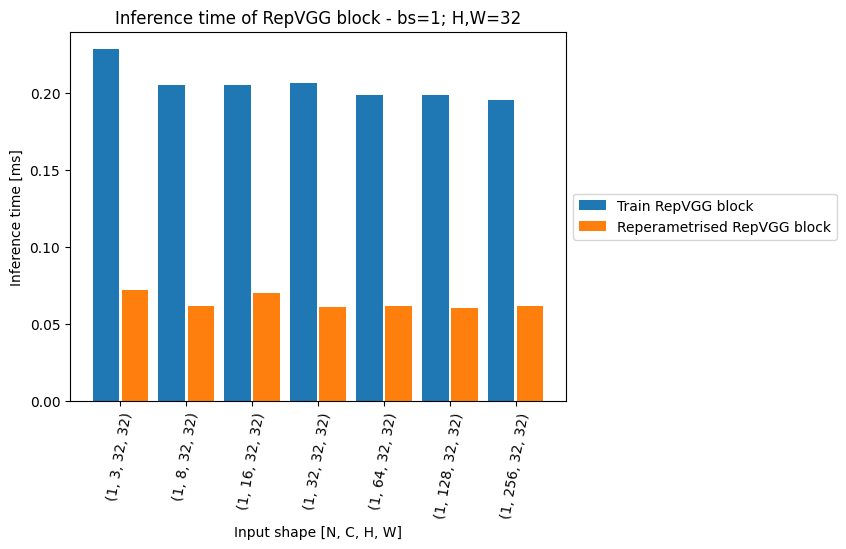

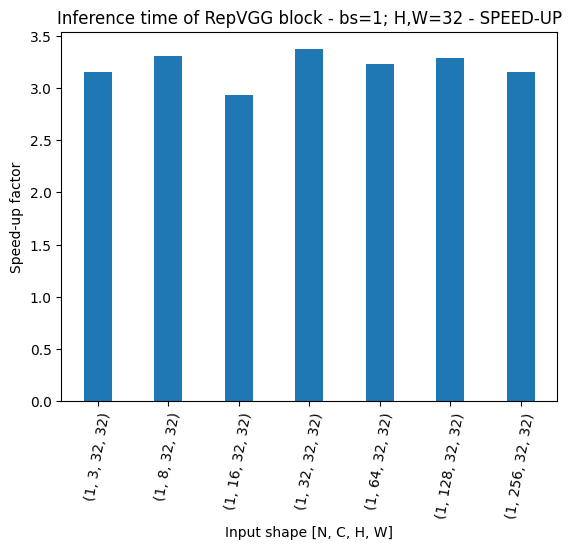

In [50]:
plot_execution_time_statistics(
    data=results,
    keys=[(1, c, 32) for c in CHANNELS],
    title="Inference time of RepVGG block - bs=1; H,W=32"
)

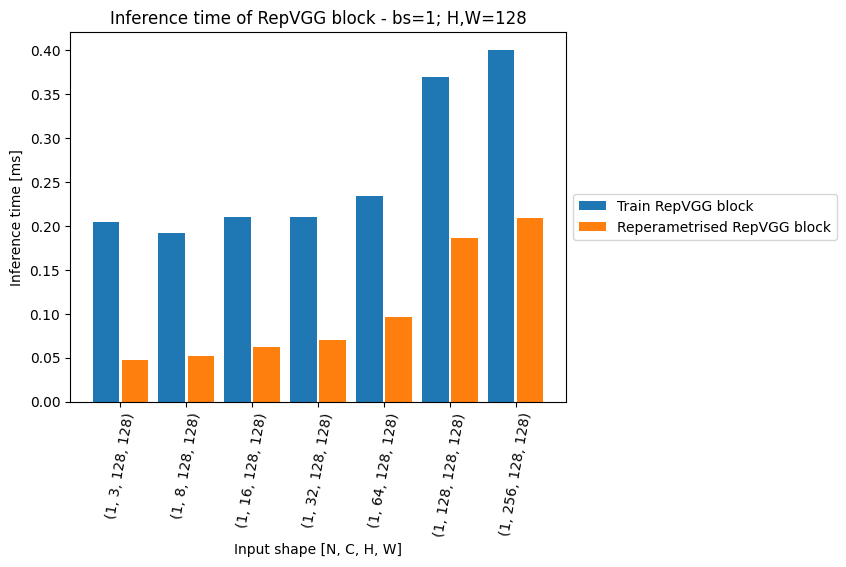

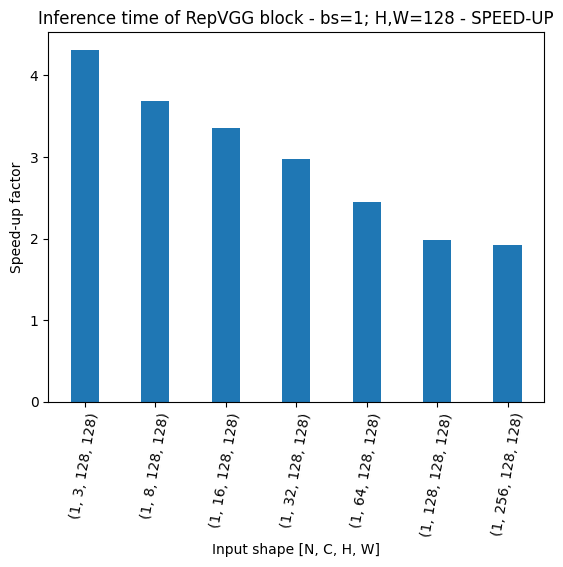

In [49]:
plot_execution_time_statistics(
    data=results,
    keys=[(1, c, 128) for c in CHANNELS],
    title="Inference time of RepVGG block - bs=1; H,W=128"
)

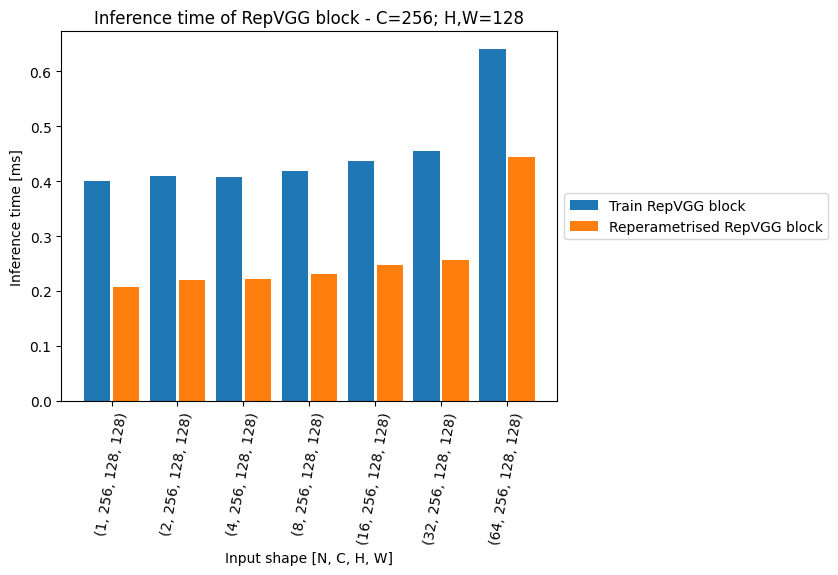

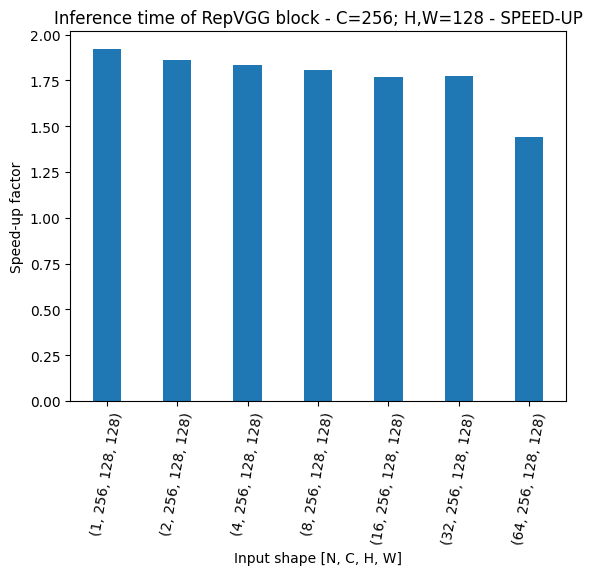

In [47]:
plot_execution_time_statistics(
    data=results,
    keys=[(bs, 256, 128) for bs in BATCH_SIZES],
    title="Inference time of RepVGG block - C=256; H,W=128"
)

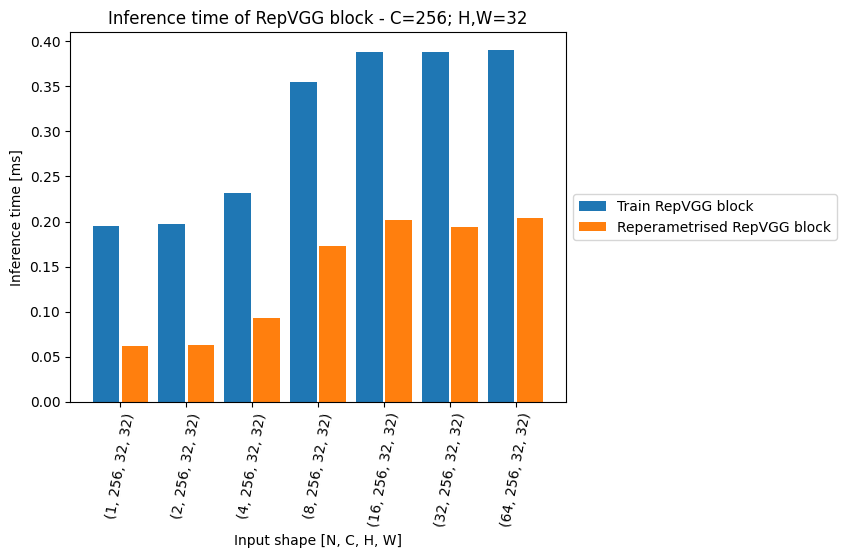

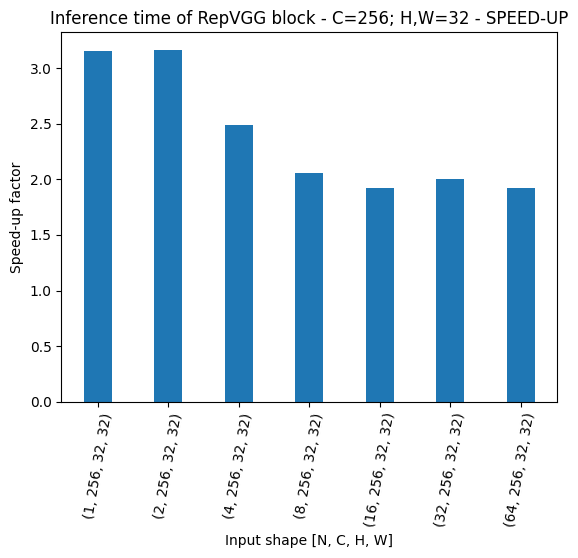

In [51]:
plot_execution_time_statistics(
    data=results,
    keys=[(bs, 256, 32) for bs in BATCH_SIZES],
    title="Inference time of RepVGG block - C=256; H,W=32"
)